# Enriching Companies House data

![title](Images/ch_screenshot.png)

This notebook gives an overview on how business data from Companies House is imported, formatting and then enriched by exploiting various APIs and websites. Examples of applications include:
-  Retrieving official company websites using Google Places API
-  Scraping websites to get keywords to classify the industry of businesses.
-  Obtaining social media accounts and handles for companies and then use these to get a proxy for their web presence (number of followers, likes etc.)

## Importing data

The Free Company Data Product is a downloadable data snapshot containing basic company data of live companies on the Companies House register, and is the principal dataset for this project. This is updated monthly and needs to be downloaded before importing as a pandas dataframe. First, we need to import some modules...

### Modules

-  Pandas: provide easy-to-use data structures in Python
-  Numpy: provides fast and efficient multidimensional arrays, in addition to linear algebra and mathematical operations.
-  Matplotlib: provides plot to visualise data

In [ ]:
import pandas as pd
from pandas import DataFrame, Series
import numpy as np

import matplotlib.pyplot as plt
# Increase figure and font sizes for easier viewing
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 14

### Loading and formatting Companies House dataset

The latest version of the Free Company Data Product can be downloaded here. http://download.companieshouse.gov.uk/en_output.html. The zip file that is downloaded is approximately 300MB, and the raw CSV file around 2GB. Once downloaded, ensure that the data is saved in the root folder of this notebook (or amend directory as required).

In [ ]:
# to-do: invesitgate warning on mixed data types
ch_raw = pd.read_csv('BasicCompanyDataAsOneFile-2018-02-01.csv')

In [ ]:
# preview the data
ch_raw.head(10) # first 10 rows 

In [ ]:
# fields available
ch_raw.columns

In [ ]:
# remove unnecessary columns for this project
# why is copy() used? See explanation at link below:
# https://stackoverflow.com/questions/27673231/why-should-i-make-a-copy-of-a-data-frame-in-pandas
ch = ch_raw.iloc[:,[0,1,4,5,6,7,8,9,10,11,12,18,19,21,26,27,28,29]].copy()

# rename columns
ch.columns = ['name','crn','address1','address2','postTown','county','country', \
            'postcode','category','status','origin','accounts_lastMadeUpDate','accountCategory',\
            'returns_lastMadeUpDate','sic1','sic2','sic3','sic4']

In [ ]:
# format missing values
ch.sic1.replace('None Supplied', np.NaN, inplace=True)
ch = ch.dropna(subset=['name']) # delete rows with null business names (usually only a few values)

In [ ]:
# Produce a range of key stats 
# Key stats
print('---------')
print('Number of businesses: %s' %len(ch))
print('Missing SIC codes: %s' %ch.sic1.isnull().sum())
sic_comp = (1.0 - (float(ch.sic1.isnull().sum())/len(ch)))*100
print('SIC code completion: %.2f' %sic_comp + '%')
post_comp = (1.0 - (float(ch.postcode.isnull().sum())/len(ch)))*100
print('Postcode completion: %.2f' %post_comp + '%')
print('---------')
print('Category breakdown (top 5)')
print('')
print(ch.category.value_counts().head())
print('---------')
print('Account category (top 5)')
print('')
print(ch.accountCategory.value_counts().head())
print('---------')
print('Geographical breakdown (top 5)')
print('')
print(ch.origin.value_counts().head())
print('---------')
print('SIC code breakdown (top 5)')
print('')
print(ch.sic1.value_counts().head())

### Data exploration

Some pandas commands to explore the dataset, including setting up a function to find companies.

In [ ]:
ch.dtypes # types of each column - all objects

In [ ]:
def find_company(name):
    '''
    Searches companies house dataset for company name which include the given input which must be a string.
    '''
    name = name.lower()
    n = ch.name.str.lower().str.contains(name)
    x = input(str(n.sum()) + ' companies found. See list of companies? Y or N? ')
    if x.lower() == 'y':
        return ch[n]
    else:
        return True

In [ ]:
find_company('Burberry') # testing function on a few cases 

In [ ]:
find_company('Dyson')

Exploring SIC codes...

In [ ]:
ch.sic1.describe() # counts occurences and unique values

Sorting by the top 20 SIC codes shows that some of these are not very descriptive. Top of the list is 'Other business support service activities n.e.c'. Third is 'Dormant Company' and this is followed by 'Other service activities n.e.c'.

In [ ]:
ch.sic1.value_counts().head(20) # sort by top 20 sic codes

In [ ]:
ch.sic1.value_counts().head(30).plot() # shows skew of top categories
plt.show()

Checking if company reference numbers are unique

In [ ]:
ch.crn.describe() # all crns are unique

In [ ]:
ch.crn.isnull().sum() # 0

Exploring the address data

In [ ]:
ch.head() # reminder of the address fields

In [ ]:
ch.address1.describe() # 1.6 million unique addresses

In [ ]:
ch.address1.isnull().sum() # 27K null addresses

In [ ]:
ch.postTown.isnull().sum() # 93K missing town names

In [ ]:
ch.postcode.isnull().sum() # 52K missing post codes

### Export formatted dataset

In [ ]:
# Export dataset, named after MMYY of ch data
ch.to_csv('ch_2018-02.csv',index=False)

Optional: remove non-UK companies 

In [ ]:
ch_uk = ch[ch['origin'].isin(['United Kingdom','Great Britain','UNITED KINGDOM','GREAT BRITAIN','ENGLAND & WALES','UK'])]
ch_uk.reset_index(inplace=True)
ch_uk.to_csv('ch_2018-02.csv',index=False)

## Scraping data from Google Search Results

This section goes through the process of running google searches of business names in Companies House, scraping text from the results, and then returning a wordcloud of text from the first page of results.

The code below builds up the code for functions that run searches and produce
worldclouds as follows:

cloud(keyWords(search('Company Name')))

- search(string): returns a list of URLs from Google for the given term
- keyWords(list): screen-scrapes all visible text from the given list of URLs, and cleans
- cloud(string): after removing a given list of stopwords, produces a wordcloud

### Importing further modules and data

In [ ]:
import webbrowser # to open web links
import nltk # natural language toolkit
from nltk.corpus import stopwords # Import the stop word list, may require download
# WordCloud modules
from wordcloud import WordCloud, STOPWORDS

import re # regular expressions 
from time import sleep # to pause web-scraper
import requests # allows you to send HTTP requests via Python
from bs4 import BeautifulSoup # beautiful soup for parsing of HTML

Read in formatted CH dataset if starting a new session. We'll refer to this at the end of the section after we've built up our tools to scrape and clean website text.

In [ ]:
ch = pd.read_csv('ch_2018-02.csv')

### Returning links for a Google Search term

First, we need to build some functionality to scrape the search results returned by Google.

In [ ]:
# Set business search term as an example
biz = 'DYSON LIMITED'

In [ ]:
# Read HTML
html = requests.get('https://www.google.co.uk/search?q='+biz)
# Parse HTML into a BeautifulSoup object
soup = BeautifulSoup(html.content, 'lxml')

In [ ]:
# Get all links and put into list
list_of_links = []
for link in soup.find_all('a'):
    list_of_links.append(link.get('href'))

In [ ]:
print(list_of_links) # needs cleaning up 

In [ ]:
# Cleaning up results
links = DataFrame({'urls':list_of_links}) #turn list into DF
links = links[links.urls.str.contains('/url?')] #Only search results

In [ ]:
# remove cached sites
links = links[links.urls.str.contains('webcache.googleusercontent') == False]

In [ ]:
# remove opening url?q= string
links = links.urls.str.replace('/url\?q=',"")
# after this, you don't need to call list anymore on the column

In [ ]:
# remove suffixed &sa bit by splitting and drop index
links = links.str.split('&sa',1).reset_index().drop('index',1)
# this is now a dataframe

In [ ]:
# use iterrows to grab first entry in each list which should be the working url
links_cleaned = []
for row in links.iterrows():
    links_cleaned.append(row[1][0][0])

In [ ]:
# convert to dataframe
links_cleaned = DataFrame(links_cleaned)

We can now bring this together in one function. Note that we're screen-scraping from Google Search results so we'll need to be careful to not overload Google with search requests in quick succession (and potentially get our IP blocked).

In [ ]:
def search_google(business_name):
    '''
    Takes in a business name and returns the links returned in the first page of Google Search results
    '''
    # Read HTML
    html = requests.get('https://www.google.co.uk/search?q='+business_name)
    # Parse HTML into a BeautifulSoup object
    soup = BeautifulSoup(html.content, 'lxml')

    # Get all links and put into list
    list_of_links = []
    for link in soup.find_all('a'):
        list_of_links.append(link.get('href'))

    # Cleaning up results
    links = DataFrame({'urls':list_of_links}) #turn list into DF
    links = links[links.urls.str.contains('/url?')] #Only search results
    
    # remove cached sites
    links = links[links.urls.str.contains('webcache.googleusercontent') == False]

    # remove opening url?q= string
    links = links.urls.str.replace('/url\?q=',"")
    # after this, you don't need to call list anymore on the column

    # remove suffixed &sa bit by splitting and drop index
    links = links.str.split('&sa',1).reset_index().drop('index',1)
    # this is now a dataframe

    # use iterrows to grab first entry in each list which should be the working url
    links_cleaned = []
    for row in links.iterrows():
        links_cleaned.append(row[1][0][0])
        
    # convert to dataframe
    links_cleaned = DataFrame(links_cleaned)

    return links_cleaned[0]

In [ ]:
burberry_links = search_google('burberry limited')

In [ ]:
# use webbrowser library to open all links in browser (if needed)
for link in burberry_links:
    webbrowser.open(link)

### Extract key text from company websites 

Now that we've got the functionality to return links from Google search results, we want to navigate to each link, scrape and format the text to find words with explanatory value after removing stopwords and other standard website text. Let's use the Dyson website as an example. 

In [ ]:
dyson_links = search_google('Dyson Limited')

In [ ]:
# Inspecting the first search result
# Read HTML
html = requests.get(dyson_links[0])
# Parse HTML into a BeautifulSoup object
soup = BeautifulSoup(html.content, 'lxml')

In [ ]:
# Extracting text from key html sections
[s.extract() for s in soup(['style', 'script', '[document]', 'head', 'title'])]

In [ ]:
# Get all visible text
text = soup.getText().encode('ascii','ignore')

We want to clean up this text by removing HTML tags and new line indicators. 

In [ ]:
text_r = str(text).replace('\\n','').replace('\\t','').replace('\\r','')
print(text_r)

In [ ]:
def stripsymbols(text):
    '''
    Use regular expressions to do a find-and-replace of HTML text.
    Function found online
    '''
    text = str(text)
    x = re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",text)
    x = re.sub('/(^|\b)@\S*($|\b)/'," ",x)
    x = re.sub('/(^|\b)#\S*($|\b)/'," ",x)
    x = re.sub("[^a-zA-Z]"," ",x)
    x = re.sub(r"(?:\@|https?\://)\S+", " ",x)
    return x

In [ ]:
text_stripped = stripsymbols(text_r)
print(text_stripped)

Getting better! The final step is remove stop words by invoking the Natural Language Toolkit Library we imported earlier. Let's see what kind of stop words are classified in the library. 

In [ ]:
print(stopwords.words('English'))

We can create a function to remove stopwords from website text.

In [ ]:
def removeStopWords(text):
    '''
    Remove stopwords from given text string
    '''
    words = [w for w in text if not w in stopwords.words("english")]
    return words

In [ ]:
# Prepare text for function by (a) changing to lowercase (2) remove whitespace from beginning and end 
# (3) splitting the text to create a list of individual wordsvisible_text_stripped.lower().strip().split() 
text_stripped_split = text_stripped.lower().strip().split()
text_stripped_split

Finally, running this through the removeStopWords function gives us something in a much better shape than the original text. 

In [ ]:
text_cleaned = removeStopWords(text_stripped_split)
text_cleaned

Wrapping this all up into a function...

In [ ]:
def cleantext(text):
    text_r = str(text).replace('\\n','').replace('\\t','').replace('\\r','')
    text_stripped = stripsymbols(text_r)
    text_stripped_split = text_stripped.lower().strip().split()
    text_cleaned = removeStopWords(text_stripped_split)
    return ' '.join(text_cleaned) # returns a joined list of the remaining words 

In [ ]:
dyson_cleaned = cleantext(text) # example of a function
dyson_cleaned

### Using the Natural Language Toolkit to tokenise and tag words

Another feature of the Natural Language Toolkit we can exploit is the ability to tag words and categorise them into their 'parts of speech' (i.e. nouns, verbs, adverbs). Perhaps this can be used to tag words from the scraped text, and retrieve nouns under the assumption that they provide the greatest explanatory power.

Let's test this with the scraped text from the previous section.

In [ ]:
dyson_cleaned

In [ ]:
tokens = nltk.word_tokenize(dyson_cleaned) # tokenize (split) the string
print(tokens)

The tags bellow are given according to the Penn Treebank Project here: https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html

The results are quite interesting. Words like 'vacuums', 'cylinders', 'robot' and 'dryers' are correctly given as nouns. However, some words are double-tagged. For instance, 'dyson' is given as a verb as well as a noun. 'Airblade' is given as a past-tense verb. 

From this example alone, filtering on nouns would yield the best results.

In [ ]:
tagged = nltk.pos_tag(tokens) # categorise words according to their parts of speech
print(tagged)

In [ ]:
# Keep nouns only
tagged_nouns = " ".join([word[0] for word in tagged if word[1] in ['NNS','NN']])
tagged_nouns

In [ ]:
# Difference in list sizes - 1,415 removed words (out of 3,767)
len(dyson_cleaned) - len(tagged_nouns)

### Master function and wordclouds

Let's collect everything we've built in Section 2 and build our final master functions.

In [170]:
def key_words(list_of_urls):
    '''
    From the given list of urls, this function scrapes, cleans (removing symbols and non-nouns)
    and gathers all text into a single string
    '''
    
    words_cleaned = '' # Set up empty string
    
    for website in list_of_urls:
        # try / except for troublesome websites
        try:
            html = requests.get(website)
            soup = BeautifulSoup(html.content, 'lxml')
            [s.extract() for s in soup(['style', 'script', '[document]', 'head', 'title'])]
            visibleText = soup.getText().encode('ascii','ignore')
            words_cleaned += cleantext(visibleText) # Calling the function we built earlier 
        except:
            continue
            
    # Tokenize and tag words
    tokens = nltk.word_tokenize(words_cleaned)
    tagged = nltk.pos_tag(tokens)

    # Keep nouns only
    keywords = " ".join([word[0] for word in tagged if word[1] in ['NNS','NN']])
    return keywords

In [172]:
key_words(search_google('Burberry Limited')) # testing on an example - takes a few seconds to run

This is best visualised in a word cloud...

In [175]:
def cloud(words):
    '''
    Function that takes in a string and produces a word cloud
    '''
    wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='black',
                          width=1800,
                          height=1400
                         ).generate(words)

    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    return wordcloud

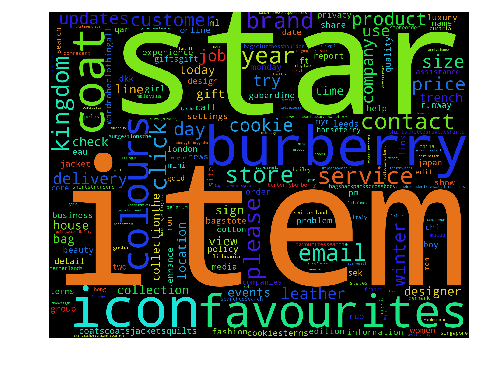

In [176]:
cloud(key_words(search_google('Burberry Limited')))

In [ ]:
cloud(key_words(search_google('')))

## Connecting to Google Places API